## Import Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from data_loader.read_mrc import read_mrc
from skimage import io
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## Set Directories

In [38]:
from data_loader.biosr_dataset import BioSRDataLoader

# Define your working directory and data directory
work_dir = "."
tensorboard_log_dir = os.path.join(work_dir, "tensorboard_logs")
os.makedirs(tensorboard_log_dir, exist_ok=True)
data_dir = '/group/jug/ashesh/data/BioSR/'


## Load Data

In [39]:
# Instantiate the dataset
resize_to_shape = (256,256)
dataset = BioSRDataLoader(root_dir=data_dir, resize_to_shape=resize_to_shape)

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the number of samples for each set
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Check dataset length
print(f"Dataset length: {len(dataset)}")

# Check a single sample
sample = dataset[1] 
print(f"Sample 1 image shape: {sample[0].shape}")
print(f"Sample 2 image shape: {sample[1].shape}")

height = sample[0].shape[0]
width = sample[0].shape[1]

# Create DataLoader for each split
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
    

# Example of iterating over the DataLoader
for batch in train_loader:
    inputs, targets = batch
    # Process your images
    print(f"Batch inputs shape: {inputs.shape}")
    print(f"Batch targets shape: {targets.shape}") 


Resizing to shape (256, 256). MUST BE REMOVED IN PRODUCTION!
c1_data shape: (256, 256, 68)
c2_data shape: (256, 256, 54)
Dataset length: 54
Sample 1 image shape: (256, 256)
Sample 2 image shape: (2, 256, 256)
Batch inputs shape: torch.Size([4, 256, 256])
Batch targets shape: torch.Size([4, 2, 256, 256])
Batch inputs shape: torch.Size([4, 256, 256])
Batch targets shape: torch.Size([4, 2, 256, 256])
Batch inputs shape: torch.Size([4, 256, 256])
Batch targets shape: torch.Size([4, 2, 256, 256])
Batch inputs shape: torch.Size([4, 256, 256])
Batch targets shape: torch.Size([4, 2, 256, 256])
Batch inputs shape: torch.Size([4, 256, 256])
Batch targets shape: torch.Size([4, 2, 256, 256])
Batch inputs shape: torch.Size([4, 256, 256])
Batch targets shape: torch.Size([4, 2, 256, 256])
Batch inputs shape: torch.Size([4, 256, 256])
Batch targets shape: torch.Size([4, 2, 256, 256])
Batch inputs shape: torch.Size([4, 256, 256])
Batch targets shape: torch.Size([4, 2, 256, 256])
Batch inputs shape: tor

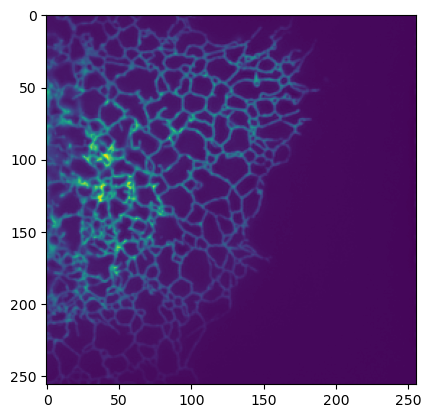

In [40]:
from skimage.transform import resize
plt.imshow(resize(dataset.c1_data, (256,256, dataset.c1_data.shape[-1]))[...,0])

## Visualize Data

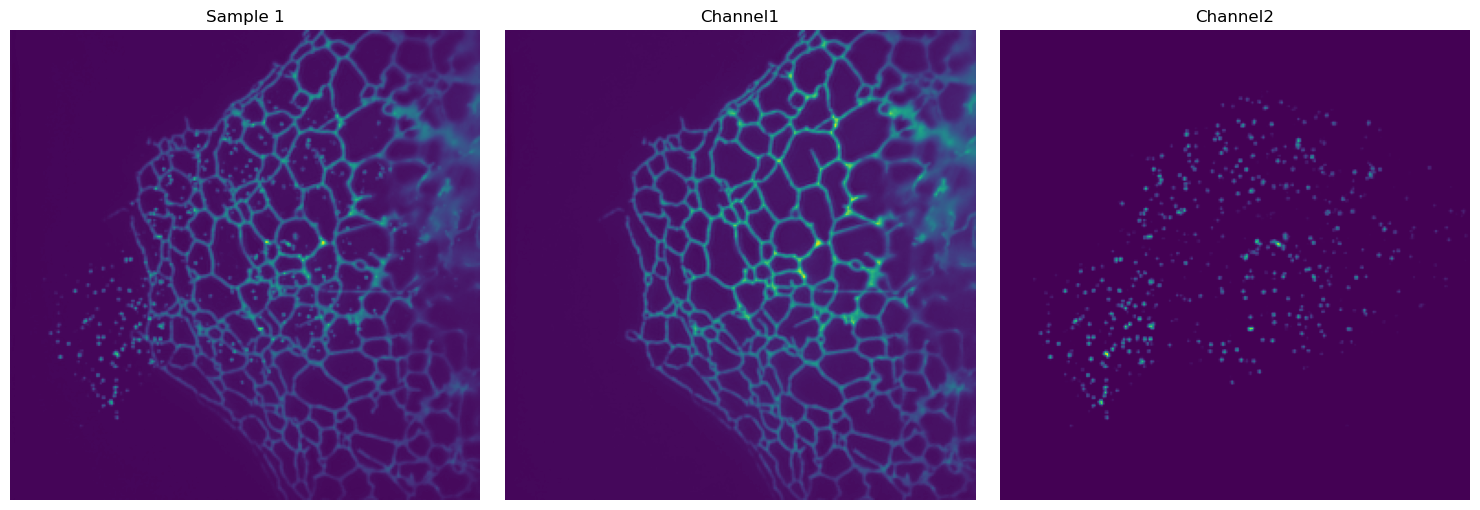

In [41]:
def display_images_in_row(images, titles=None, cmap='viridis'):
    """
    Display a list of images in a row with optional titles.
    
    Args:
        images (list of np.ndarray): List of images to display.
        titles (list of str): List of titles for each subplot (default is None).
        cmap (str): Colormap to use for displaying images (default is 'viridis').
    """
    n_images = len(images)
    
    _, axes = plt.subplots(1, n_images, figsize=(15, 5))  # Create a row of subplots
    
    if titles is None:
        titles = [''] * n_images  # If no titles are provided, use empty strings
    
    for ax, image, title in zip(axes, images, titles):
        # Check if the image is 3D (e.g., for color images or multi-channel images)
        if len(image.shape) == 3 and image.shape[-1] in [3, 4]:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')  # Hide axis
    
    plt.tight_layout()
    plt.show()

# Assuming sample1, sample2, input, and target are your image arrays
images = [sample[0], sample[1][0], sample[1][1]]
titles = ['Sample 1', 'Channel1', 'Channel2']

display_images_in_row(images, titles)


## Create Model

### Swin2SR

In [42]:
from models.network_swin2sr import Swin2SR

In [43]:
# depths = [6, 6, 6, 6]
# num_heads = [6, 6, 6, 6]
depths = [3, 3]
num_heads = [3, 3]

from tests.training import Swin2SRModule
from configs.biosr_config import get_config

config = get_config()

# Initialize the model
model = Swin2SRModule(config)


model.load_state_dict(torch.load('/home/michele.prencipe/tesi/transformer/swin2sr/logdir/swin2sr_epoch400_valloss0.0003_1725617981.pth'))

<All keys matched successfully>

## Inference

In [44]:
from loss.charbonnier_loss import CharbonnierLoss
from torch import nn as nn
# Validation loop (optional but recommended)
model.eval()  # Set model to evaluation mode
model = model.cuda()

criterion = nn.MSELoss()
val_loss = 0.0
test_inputs = []
test_outputs = []
test_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.cuda(), targets.cuda()

        # Ensure inputs and targets have the correct dimensions
        if len(inputs.shape) == 3:  # If inputs are [batch_size, height, width]
            inputs = inputs.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
        if len(targets.shape) == 3:  # If targets are [batch_size, height, width]
            targets = targets.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]

        outputs = model(inputs)  # Forward pass
        
        test_inputs.append(inputs.cpu().numpy())
        test_outputs.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())

        # Ensure outputs and targets have the same dimensions for loss computation
        if outputs.shape != targets.shape:
            print(f"Output shape: {outputs.shape}, Target shape: {targets.shape}")
            raise ValueError("Output and target shapes do not match!")
        
        loss = criterion(outputs, targets)  # Compute loss
        val_loss += loss.item()  # Accumulate loss

test_inputs = np.concatenate(test_inputs, axis=0)
test_outputs = np.concatenate(test_outputs, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# Compute average validation loss for the epoch
val_loss = val_loss / len(test_loader)
print(f'Validation Loss: {val_loss:.7f}')


Validation Loss: 0.0001996


## Metric Calculation

In [48]:
from collections import defaultdict
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

psnr_arr = {0: [], 1: []}
ssim_arr = defaultdict(list)

for i in range(len(test_inputs)):
    for ch_idx in range(test_outputs.shape[1]):
        psnr_arr[ch_idx].append(psnr(test_targets[i,ch_idx], test_outputs[i,ch_idx]))
        ssim_arr[ch_idx].append(ssim(test_targets[i,ch_idx], test_outputs[i,ch_idx], data_range=1.0))
    

In [49]:
print("psnr channel 1:", np.mean(psnr_arr[0]))
print("psnr channel 2:", np.mean(psnr_arr[1]))
print("ssim channel 1:", np.mean(ssim_arr[0]))
print("ssim channel 2:", np.mean(ssim_arr[1]))

psnr channel 1: 36.75116345816344
psnr channel 2: 38.24257098884881
ssim channel 1: 0.8960580256655662
ssim channel 2: 0.9410951918457723


## Visual Evaluation

Index: 4


Text(0.5, 1.0, 'Target')

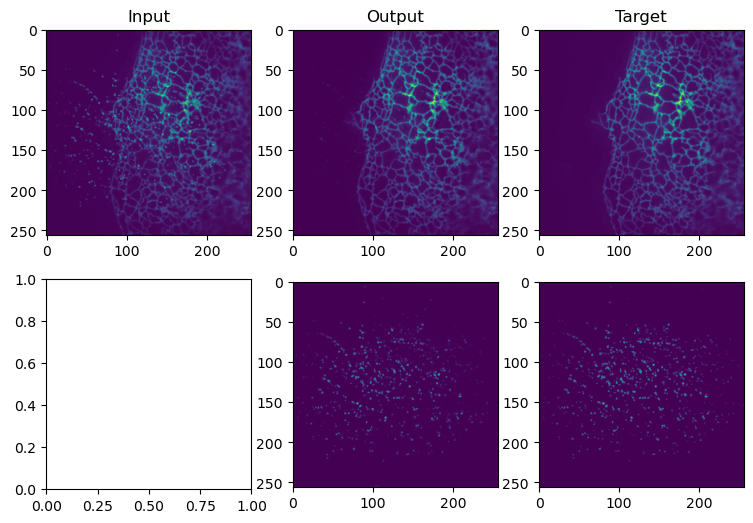

In [50]:
idx = np.random.randint(0,len(test_inputs))
print(f"Index: {idx}")
img_sz = 3
ncols = 3
nrows = 2
_, ax = plt.subplots(figsize=(img_sz*ncols, img_sz*nrows), ncols=ncols,nrows=nrows)
ax[0,0].imshow(test_inputs[idx,0])
ax[0,1].imshow(test_outputs[idx,0], vmax = np.max(test_targets[idx,0]), vmin=np.min(test_targets[idx,0]))
ax[0,2].imshow(test_targets[idx,0])
ax[1,1].imshow(test_outputs[idx,1], vmax = np.max(test_targets[idx,1]), vmin=np.min(test_targets[idx,1]))
ax[1,2].imshow(test_targets[idx,1])

ax[0,0].set_title('Input')
ax[0,1].set_title('Output')
ax[0,2].set_title('Target')

In [ ]:
def augment_data(X_train):
    """Augment data by 8-fold with 90 degree rotations and flips.
    Parameters
    ----------
    X_train: numpy array
        Array of training images.
    """
    X_ = X_train.copy()
    X_train_aug = np.concatenate((X_train, np.rot90(X_, 1, (1, 2))))
    X_train_aug = np.concatenate((X_train_aug, np.rot90(X_, 2, (1, 2))))
    X_train_aug = np.concatenate((X_train_aug, np.rot90(X_, 3, (1, 2))))
    X_train_aug = np.concatenate((X_train_aug, np.flip(X_train_aug, axis=1)))
    return X_train_aug